In [1]:
# Intro

In [2]:
#A00

# Libraries for data loading, data manipulation
import pandas as pd
import re

# Libraries for mathematical analyses
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
#import missingno as msno

!pip install surprise
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

import operator
import heapq
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp

#Libraries to test accuracy
from surprise import accuracy

#Library for creating pickle files of the models
import pickle

### Import Data

In [3]:
#A00

tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies = pd.read_csv('movies.csv')
imdb = pd.read_csv('imdb_data.csv')

### Check memory usage

In [4]:
def view_memory_usage(df, verbose = True):
    mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage is {:.2f} Mb \n".format(mem))
    return

In [5]:
print('Train df:')
view_memory_usage(train, verbose = True)
print('Test df:')
view_memory_usage(test , verbose = True)
print('Movies df:')
view_memory_usage(movies, verbose = True)
print('Tags df:')
view_memory_usage(tags, verbose = True)
print('IMDB df:')
view_memory_usage(imdb, verbose = True)

Train df:
Memory usage is 305.18 Mb 

Test df:
Memory usage is 76.29 Mb 

Movies df:
Memory usage is 1.43 Mb 

Tags df:
Memory usage is 33.37 Mb 

IMDB df:
Memory usage is 1.25 Mb 



### Reduce memory

In [6]:
#A00
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

Now that the function has been successfully initialized we can apply it to the dataset

In [7]:
#A00
train_df = reduce_memory_usage(train, verbose=True)
test_df= reduce_memory_usage(test, verbose=True)
movies_df= reduce_memory_usage(movies, verbose=True)
tags_df= reduce_memory_usage(tags, verbose=True)
imdb_df= reduce_memory_usage(imdb, verbose=True)

Mem. usage decreased to 152.59 Mb (50.0% reduction)
Mem. usage decreased to 38.15 Mb (50.0% reduction)
Mem. usage decreased to 1.19 Mb (16.7% reduction)
Mem. usage decreased to 20.85 Mb (37.5% reduction)
Mem. usage decreased to 1.04 Mb (16.7% reduction)


### View the data

In [8]:
#Loop through each dataframe and view a sneakpeak of it

data_list = [movies_df, imdb_df, tags_df, train_df]
for df in data_list:
    print(df.head())
    print('------------')

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
------------
   movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

 

In [9]:
#Create a df that captures unique elements of movies, users, tags, and directors

unique_entries_per_df = pd.DataFrame({"movies": len(movies_df.movieId.unique().tolist()),
                       "tags" : len(tags_df.tag.unique().tolist()),
                       "users": len(train_df.userId.unique().tolist()),
                       "directors" : len(imdb_df.director.unique().tolist())}, index=['unique_value_count'])

unique_entries_per_df.T.head()

,unique_value_count
movies,62423
tags,73051
users,162541
directors,11787


### Observation
The datasets have 60000+ individual movie records, over 70000 tags, 150000+ users who rated the movies. For more specificity, we looked at directors, and found that over 10000 directors were involved.

### GRAPHS

#### 1. Visualise the count of ratings

In [10]:
#Merge the train and movies dataframes

merged_train = train_df.merge(movies_df, on='movieId', how='inner')
merged_train.drop('timestamp', axis=1, inplace=True)
merged_train.head()

,userId,movieId,rating,title,genres
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [11]:
#Create a new dataframe from columns in the merged_train df

new_df = pd.DataFrame(merged_train.groupby(['rating'])['title'].count())
new_df.rename(columns={'title':'total_ratings'}, inplace=True)
new_df

,total_ratings
rating,
0.5,157571
1.0,311213
1.5,159731
2.0,656821
2.5,505578
3.0,1959759
3.5,1270642
4.0,2652977
4.5,880516


In [12]:
print("The lowest rating is :",new_df.index.min())
print("The highest rating is :",new_df.index.max())

The lowest rating is : 0.5
The highest rating is : 5.0


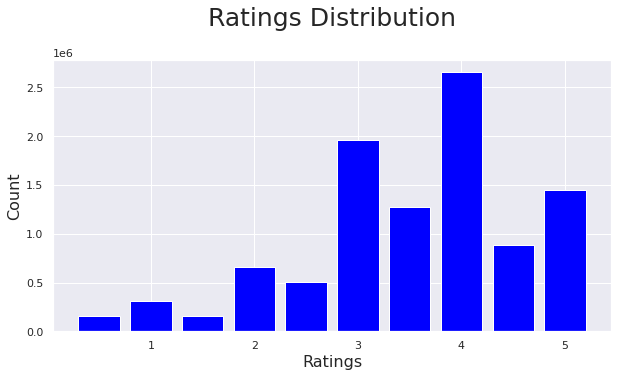

In [13]:
# Plot Bargraph

y = list(new_df.total_ratings)
x = list(new_df.index)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='blue',
        width = 0.4)
 
plt.xlabel("Ratings", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Ratings Distribution\n", fontsize=25)
plt.show()

### Observation
Ratings range from 0.5 to 5.0. The most used rating is 4, followed by 3. This suggests that users have a neutral to positive overview of the movies in the MovieLens dataset

#### 2. Visualise the count of average ratings

In [14]:
new_df_2 = pd.DataFrame(merged_train.groupby(['title'])[['rating']].mean())
new_df_2['total_ratings'] = pd.DataFrame(merged_train.groupby(['title'])['rating'].count())
new_df_2.rename(columns={'rating':'average_ratings'}, inplace=True)
new_df_2.head()

,average_ratings,total_ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


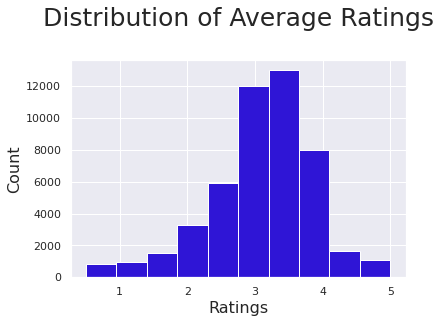

In [15]:
# Plot Histogram

fig = plt.Figure(figsize=(20,5))
plt.hist(new_df_2['average_ratings'], bins=10, color='#2f15d6')
#plt.set_title('Average ratings\n', fontsize=25)
plt.title('Distribution of Average Ratings\n', fontsize=25)
plt.xlabel('Ratings', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

### Observation
The graph displays a normal distribution, with the mean rating around 3.

### Lets look at the top 10 most popular movies

In [16]:
#Add a popularity score column, which will list the most popular movies

new_df_2['popularity_score'] = pd.DataFrame(merged_train.groupby(['title'])['rating'].count() * merged_train.groupby(['title'])['rating'].mean())
popularity_df = new_df_2.sort_values(by='popularity_score', ascending=False).head(10)
popularity_df

,average_ratings,total_ratings,popularity_score
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145034.997782
Pulp Fiction (1994),4.195097,31697,132972.003760
Forrest Gump (1994),4.047216,32383,131060.993739
"Silence of the Lambs, The (1991)",4.144172,29444,122021.006010
"Matrix, The (1999)",4.154253,29014,120531.496716
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.502457
Schindler's List (1993),4.247625,24004,101959.998924
Fight Club (1999),4.227906,23536,99508.000961
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.003250


### Observation 
Above are the top ten most popular movies in our set
Shawshank Redemption, starring Morgan Freeman, rated as the most popular movie, with an average rating of 4.4. We consider the popularity rating above the raw highest rating because the popularity score factors in the number of ratings. A movie with one five-star rating doesn't say much about the quality of movie since the opinion of one user cannot be used to infer quality.

Other popular movies include Pulp Fiction, The Matrix, Fight Club, and Star Wars. These are 80s and 90s cult classics, and thus makes sense that they would rank so high on popularity.

#### 3. Visualise the year of release (for Streamlit App)

In [17]:
# Extract the release year fron the movie titles
from datetime import datetime

# Changing the Timestamp column to Datetime data type
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))



train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,2018-02-11 11:53:12
1,106343,5,4.5,2008-03-23 02:18:59
2,146790,5459,5.0,2004-02-08 04:45:39
3,106362,32296,2.0,2015-02-04 09:36:05
4,9041,366,3.0,1996-05-29 13:17:17


In [18]:
# Here we split the Timestamp column into year, month, day of week and hour, so as to help analyse the data better
train_df['rating_year'] = pd.to_datetime(train_df['timestamp']).dt.year
train_df['month'] = pd.DatetimeIndex(train_df['timestamp']).month
train_df['day_of_week'] = pd.DatetimeIndex(train_df['timestamp']).dayofweek
train_df['hour_of_day'] = pd.DatetimeIndex(train_df['timestamp']).hour

# Change the numbers on the day_of_week column to actual names of days so that we can derive insights better from the data set
days = { 0: 'Mon', 1: 'Tue', 2: 'Wed', 3:'Thurs', 4:'Fri', 5: 'Sat', 6: 'Sun'}

train_df['day_of_week'] = train_df['day_of_week'].apply(lambda x: days[x])

train_df.head()

,userId,movieId,rating,timestamp,rating_year,month,day_of_week,hour_of_day
0,5163,57669,4.0,2018-02-11 11:53:12,2018,2,Sun,11
1,106343,5,4.5,2008-03-23 02:18:59,2008,3,Sun,2
2,146790,5459,5.0,2004-02-08 04:45:39,2004,2,Sun,4
3,106362,32296,2.0,2015-02-04 09:36:05,2015,2,Wed,9
4,9041,366,3.0,1996-05-29 13:17:17,1996,5,Wed,13


In [19]:
merged_train_2 = train_df.merge(movies_df, on='movieId', how='inner')
merged_train_2.head()

,userId,movieId,rating,timestamp,rating_year,month,day_of_week,hour_of_day,title,genres
0,5163,57669,4.0,2018-02-11 11:53:12,2018,2,Sun,11,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,2009-03-19 09:34:57,2009,3,Thurs,9,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,2015-03-06 08:50:54,2015,3,Fri,8,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,2014-08-16 22:35:17,2014,8,Sat,22,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,2015-11-08 00:14:00,2015,11,Sun,0,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [20]:
#Plotting the number of movies released per year
'''import re

merged_train_2['release_year'] = merged_train_2['title'].map(lambda x: re.findall('\d\d\d\d', x))

merged_train_2['release_year'] = merged_train_2['release_year'].apply(lambda x: np.nan if not x else int(x[-1]))

years_df =  pd.DataFrame(ratings.groupby(['release_year'])['movieId'].count())
years_df.rename(columns={'movieId':'number_of_movies_released'}, inplace=True)
'''

"import re\n\nmerged_train_2['release_year'] = merged_train_2['title'].map(lambda x: re.findall('\\d\\d\\d\\d', x))\n\nmerged_train_2['release_year'] = merged_train_2['release_year'].apply(lambda x: np.nan if not x else int(x[-1]))\n\nyears_df =  pd.DataFrame(ratings.groupby(['release_year'])['movieId'].count())\nyears_df.rename(columns={'movieId':'number_of_movies_released'}, inplace=True)\n"

In [21]:
# Plot the number of movies released per year
'''plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years_df, dashes=False, legend=False, palette='Blues')

# Add figure labels
plt.title('Movies released per year\n', fontsize=25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Number of movies released', fontsize=16)


plt.show() '''

"plt.figure(figsize=(10,5))\nplot = sns.lineplot(data=years_df, dashes=False, legend=False, palette='Blues')\n\n# Add figure labels\nplt.title('Movies released per year\n', fontsize=25)\nplt.xlabel('Years', fontsize=16)\nplt.ylabel('Number of movies released', fontsize=16)\n\n\nplt.show() "

In [22]:
#Merge the imdb and movies df

merged_imdb = movies_df.merge(imdb_df, on='movieId', how='inner')
merged_imdb.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


### 4. Visualise the top 10 directors

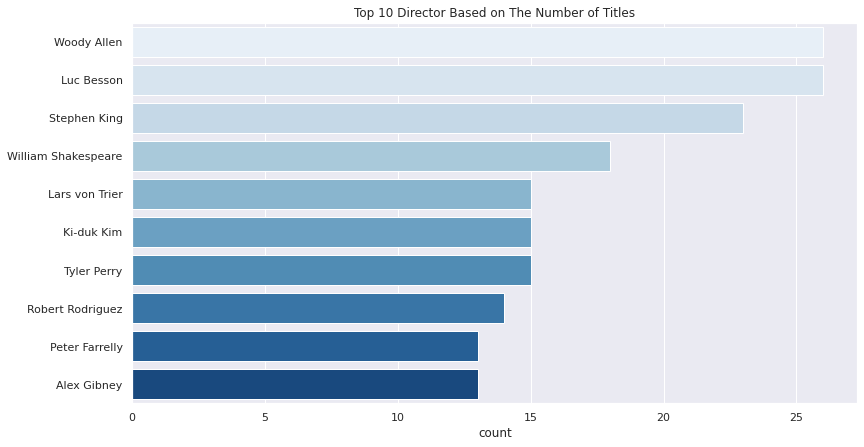

In [23]:

merged_imdb.director.fillna("No Director", inplace=True)
merged_imdb.title_cast.fillna("No Cast", inplace=True)

filtered_directors = merged_imdb[(merged_imdb.director != 'No Director') & (merged_imdb.director != 'See full summary')].set_index('title').director.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

plt.figure(figsize=(13,7))
plt.title('Top 10 Director Based on The Number of Titles')
sns.countplot(y = filtered_directors, order=filtered_directors.value_counts().index[:10], palette='Blues')

plt.show()

### Observation
Woody Allen is the most occuring director, besides Luc Besson, and Stephen King.

### 5. Visualise the genres count

In [25]:
movies_df2 = movies_df.copy()
movies_df2['genres'] = movies_df2.genres.astype(str)
movies_df2['genres'] = movies_df2['genres'].map(lambda x: x.lower().split('|'))
movies_df2['genres'] = movies_df2['genres'].apply(lambda x: " ".join(x))
movies_df2.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [26]:
unique_genres = []
for genre in movies_df2.genres:
    for gen in genre.split():
        unique_genres.append(gen)

unique_genres = set(unique_genres)
len(unique_genres)

22

In [28]:
genre_list = list(unique_genres)
genre_list.append('no genres listed')
genre_list.pop(-5)
genre_list.pop(0)
genre_list.pop(7)
genre_list


['thriller',
 'western',
 'musical',
 '(no',
 'documentary',
 'adventure',
 'romance',
 'imax',
 'film-noir',
 'comedy',
 'action',
 'war',
 'genres',
 'mystery',
 'crime',
 'drama',
 'horror',
 'children',
 'fantasy',
 'no genres listed']

In [50]:
genre_list.pop(3)
genre_list.append('animation')


In [35]:
dictionary = {}
for genre in genre_list:
    dictionary[genre] = ','.join([genres.replace('|',',').lower() for genres in movies_df.genres]).count(genre)
dictionary

{'thriller': 8654,
 'western': 1399,
 'musical': 1054,
 'documentary': 5605,
 'adventure': 4145,
 'romance': 7719,
 'imax': 195,
 'film-noir': 353,
 'comedy': 16870,
 'action': 7348,
 'war': 1874,
 'genres': 5062,
 'mystery': 2925,
 'crime': 5319,
 'drama': 25606,
 'horror': 5989,
 'children': 2935,
 'fantasy': 2731,
 'no genres listed': 5062,
 'animation': 2929}

In [48]:
#Sort the genres according to their frequency
sorted_dictionary = sorted(dictionary.items(), key=lambda x: x[1],reverse=True)
genre, frequency = zip(*sorted_dictionary)

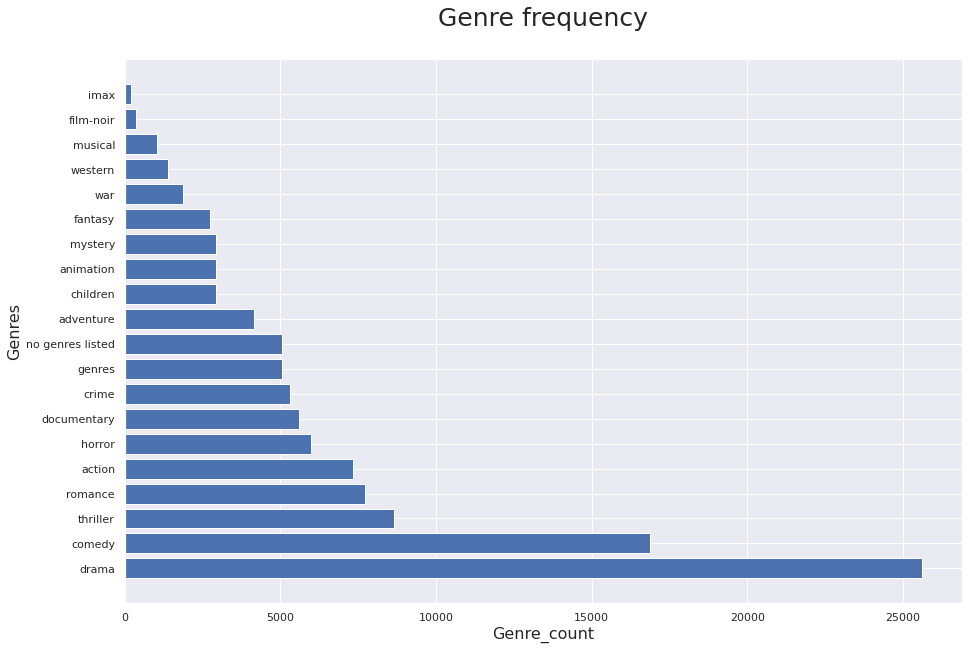

In [49]:
#Show Barplot 

fig = plt.figure(4, figsize=(15,10))
plt.barh(*zip(*sorted_dictionary))
plt.title('Genre frequency\n',fontsize=25)
plt.xlabel('Genre_count', fontsize=16)
plt.ylabel('Genres', fontsize=16)
    
plt.show()

### Observation
Drama is the most popular genre among the movies, showing up in over 25000 movies.
Comedy and Thillers are next. 
About 5000 movies were not allocated a specific genre.

In [62]:
#!pip install wordcloud

### 6. Visualise the most popular actors

In [58]:
merged_imdb = merged_imdb2.copy()

In [59]:
merged_imdb.head(1)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation


In [60]:
merged_imdb['title_cast'] = merged_imdb.title_cast.astype(str)
merged_imdb['title_cast'] = merged_imdb['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))
merged_imdb['title_cast'] = merged_imdb['title_cast'].map(lambda x: x.split('|')[:5])
merged_imdb['title_cast'] = merged_imdb['title_cast'].apply(lambda x: " ".join(x for x in x))
merged_imdb.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,tomhanks timallen donrickles jimvarney wallace...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,robinwilliams jonathanhyde kirstendunst bradle...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


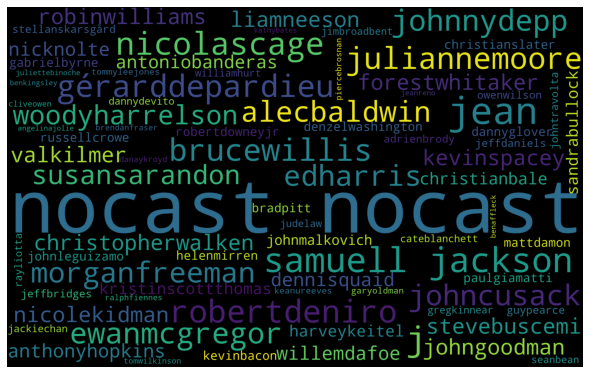

In [61]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
 
#iterate through the csv file
for val in merged_imdb.title_cast:
     
    #typecaste each val to string
    #val = str(val)
 
    #split the value
    tokens = val.split()
     
    #converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 500,
                background_color ='black',
                stopwords = stopwords,
                max_words =2000,
                max_font_size = 110,
                scale=3,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Observation
According to our WordCloud, a lorge portion of movies have 'no cast' where a title cast should be. However, we seesome popular names such as Morgan Freeman, Samuel Jackson, Bruce Willis, Johnny Depp, Robert deNiro, and John Cusack. These are some of the biggest names in Hollywood, starring in blockbuster flicks regularly.